In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras import backend as K

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7574379227863431877
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4963368960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15516034772602226166
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
def df_to_x_y(df):
    df = df.reset_index(drop=True)
    y_train = df[['target_carbon_monoxide','target_benzene','target_nitrogen_oxides']]
    x_train = df.drop(columns= ['target_carbon_monoxide','target_benzene','target_nitrogen_oxides'],axis = 1)
    x_train, x_valid , y_train,y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=23)
    return x_train,y_train, x_valid, y_valid

def feature_engine(df):
    df = df.reset_index(drop = True)
    # datetime_processing
    datatime = df['date_time']
    df['hour'] = pd.to_datetime(df['date_time']).dt.hour
    df['hour'] = abs(df['hour']-12)/12

    df['month'] = pd.to_datetime(df['date_time']).dt.month
    df['month'] = abs(df['hour']-6)/6

    df = df.drop(['date_time'],axis = 1)
    
    # adjust mean_deg_c
    gap = 1

    mean_deg_c = df['deg_C'].copy()
    change = 0
    for i in range(1,len(mean_deg_c)-1):
        #increase too much
        if mean_deg_c[i-1] - mean_deg_c[i] >  gap:
            mean_deg_c[i] = mean_deg_c[i-1] - gap
            change +=1
        #decrease too much
        if mean_deg_c[i-1] - mean_deg_c[i] <  gap*-1:
            mean_deg_c[i] = mean_deg_c[i-1] + gap
            change +=1
    df['mean_deg_c'] = mean_deg_c
    df = df.drop(['deg_C'],axis = 1)
    df = pd.DataFrame(df)
    return df ,datatime

def df_to_series(df,step = 12):
    for idx in range(step,len(df)):
        if idx == step:
            series_df = [df[idx-step:idx].values]
        else :
            series_df = np.concatenate([series_df,[df[idx-step:idx].values]],axis = 0)
    return series_df


In [3]:
origin_train = pd.read_csv("train.csv")
origin_test = pd.read_csv('test.csv')
print(list(origin_train.columns))

['date_time', 'deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']


In [4]:
print(origin_train.head(),'\n',origin_test.head())

             date_time  deg_C  relative_humidity  absolute_humidity  sensor_1  \
0  2010-03-10 18:00:00   13.1               46.0             0.7578    1387.2   
1  2010-03-10 19:00:00   13.2               45.3             0.7255    1279.1   
2  2010-03-10 20:00:00   12.6               56.2             0.7502    1331.9   
3  2010-03-10 21:00:00   11.0               62.4             0.7867    1321.0   
4  2010-03-10 22:00:00   11.9               59.0             0.7888    1272.0   

   sensor_2  sensor_3  sensor_4  sensor_5  target_carbon_monoxide  \
0    1087.8    1056.0    1742.8    1293.4                     2.5   
1     888.2    1197.5    1449.9    1010.9                     2.1   
2     929.6    1060.2    1586.1    1117.0                     2.2   
3     929.0    1102.9    1536.5    1263.2                     2.2   
4     852.7    1180.9    1415.5    1132.2                     1.5   

   target_benzene  target_nitrogen_oxides  
0            12.0                   167.7  
1         

In [5]:
none_train = origin_train.copy()
print(len(none_train))
for i in  range(1,len(none_train.columns)):
    target = none_train.iloc[:,i]
    scope = target.mean()+(target.std()*2)
    column_name = none_train.columns[i]
    none_train = none_train[none_train[column_name]<float(scope)]
    print(f'{none_train.columns[i]}:{len(none_train)}')
clean_df = none_train.copy()

7111
deg_C:6873
relative_humidity:6775
absolute_humidity:6638
sensor_1:6368
sensor_2:6200
sensor_3:5846
sensor_4:5706
sensor_5:5513
target_carbon_monoxide:5276
target_benzene:5082
target_nitrogen_oxides:4809


In [6]:
df = clean_df.copy()
df ,datatime = feature_engine(df)
x_train,y_train,x_valid, y_valid = df_to_x_y(df)
min_max_scaler = preprocessing.MinMaxScaler()
x_train = pd.DataFrame(min_max_scaler.fit_transform(x_train))
x_valid = pd.DataFrame(min_max_scaler.fit_transform(x_valid))
print(x_train)


             0         1         2         3         4         5         6  \
0     0.317872  0.562694  0.488849  0.723723  0.272981  0.772650  0.659181   
1     0.536153  0.722544  0.517427  0.588904  0.223217  0.802924  0.664698   
2     0.268759  0.630858  0.206097  0.213932  0.593609  0.527579  0.089051   
3     0.440655  0.487742  0.472263  0.731600  0.384349  0.642694  0.349444   
4     0.518417  0.251126  0.295192  0.138758  0.966311  0.360186  0.135442   
...        ...       ...       ...       ...       ...       ...       ...   
3842  0.368349  0.400737  0.242071  0.230587  0.876600  0.365281  0.199394   
3843  0.508868  0.528524  0.107363  0.260072  0.543748  0.382633  0.230943   
3844  0.609823  0.656954  0.371064  0.532185  0.313697  0.714391  0.531743   
3845  0.271487  0.260781  0.346632  0.580239  0.352969  0.539688  0.305385   
3846  0.237381  0.244222  0.273114  0.256696  0.851670  0.347781  0.069936   

             7         8         9  
0     0.833333  0.166667  

In [9]:
per_step = 24
def df_to_series(df,step = per_step):
    for idx in range(step,len(df)):
        if idx == step:
            series_df = [df[idx-step:idx].values]
        else :
            series_df = np.concatenate([series_df,[df[idx-step:idx].values]],axis = 0)
    return series_df

In [10]:
x_train_series = df_to_series(x_train).astype('float32')
y_train_series = y_train[per_step:].values
x_valid_series = df_to_series(x_valid).astype('float32')
y_valid_series = y_valid[per_step:].values

In [11]:
def loss_rmsle(pred , actual):
    return K.sqrt(K.mean(K.square(K.mean(K.log(pred + 1)-K.log(actual +1)))))

In [27]:
model0 = keras.Sequential()
model0.add(keras.layers.LSTM(5,input_shape = (per_step,x_train.shape[1])))
model0.add(keras.layers.Dense(1))
model0.compile(optimizer = 'adam', loss = loss_rmsle,metrics =[loss_rmsle])

model1 = keras.Sequential()
model1.add(keras.layers.LSTM(5,input_shape = (per_step,x_train.shape[1])))
model1.add(keras.layers.Dense(1))
model1.compile(optimizer = 'adam', loss = loss_rmsle,metrics =[loss_rmsle])

model2 = keras.Sequential()
model2.add(keras.layers.LSTM(5,input_shape = (per_step,x_train.shape[1])))
model2.add(keras.layers.Dense(1))
model2.compile(optimizer = 'adam', loss = loss_rmsle,metrics =[loss_rmsle])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = 'E:\jupyter\mygithub\Tabular-Playground-Series',
    save_weights_only = False,
    monitor = loss_rmsle,
    mode = 'min',
    save_best_only = True)

model_early_stop = keras.callbacks.EarlyStopping(
    monitor = 'loss_rmsle',
    patience = 3,
)

In [28]:
model0.fit(x_train_series,y_train_series[:,0],epochs=250, batch_size=50 ,callbacks=[model_checkpoint_callback,model_early_stop])


Train on 3823 samples
Epoch 1/250
3823/3823 [==============================] - 1s 386us/sample - loss: 0.1215 - loss_rmsle: 0.1206
Epoch 2/250
3823/3823 [==============================] - 0s 72us/sample - loss: 0.0397 - loss_rmsle: 0.0395
Epoch 3/250
3823/3823 [==============================] - 0s 74us/sample - loss: 0.0417 - loss_rmsle: 0.0422
Epoch 4/250
3823/3823 [==============================] - 0s 74us/sample - loss: 0.0338 - loss_rmsle: 0.0339
Epoch 5/250
3823/3823 [==============================] - 0s 76us/sample - loss: 0.0402 - loss_rmsle: 0.0404
Epoch 6/250
3823/3823 [==============================] - 0s 80us/sample - loss: 0.0370 - loss_rmsle: 0.0376
Epoch 7/250
3823/3823 [==============================] - 0s 68us/sample - loss: 0.0378 - loss_rmsle: 0.0376


In [29]:
model1.fit(x_train_series,y_train_series[:,1],epochs=250, batch_size=50,callbacks=[model_checkpoint_callback,model_early_stop])


Train on 3823 samples
Epoch 1/250
3823/3823 [==============================] - 2s 394us/sample - loss: 1.1303 - loss_rmsle: 1.1307
Epoch 2/250
3823/3823 [==============================] - 0s 69us/sample - loss: 0.7514 - loss_rmsle: 0.7486
Epoch 3/250
3823/3823 [==============================] - 0s 72us/sample - loss: 0.5376 - loss_rmsle: 0.5354
Epoch 4/250
3823/3823 [==============================] - 0s 73us/sample - loss: 0.4220 - loss_rmsle: 0.4221
Epoch 5/250
3823/3823 [==============================] - 0s 98us/sample - loss: 0.3328 - loss_rmsle: 0.3328
Epoch 6/250
3823/3823 [==============================] - 0s 96us/sample - loss: 0.2573 - loss_rmsle: 0.2572
Epoch 7/250
3823/3823 [==============================] - 0s 77us/sample - loss: 0.1935 - loss_rmsle: 0.1925
Epoch 8/250
3823/3823 [==============================] - 0s 70us/sample - loss: 0.1386 - loss_rmsle: 0.1394
Epoch 9/250
3823/3823 [==============================] - 0s 92us/sample - loss: 0.0980 - loss_rmsle: 0.0991
Epoch

In [31]:
model2.fit(x_train_series,y_train_series[:,2],epochs=400, batch_size=50,callbacks=[model_checkpoint_callback,model_early_stop])

Train on 3823 samples
Epoch 1/400
3823/3823 [==============================] - 0s 70us/sample - loss: 1.6509 - loss_rmsle: 1.6516
Epoch 2/400
3823/3823 [==============================] - 0s 68us/sample - loss: 1.6353 - loss_rmsle: 1.6359
Epoch 3/400
3823/3823 [==============================] - 0s 72us/sample - loss: 1.6200 - loss_rmsle: 1.6187
Epoch 4/400
3823/3823 [==============================] - 0s 72us/sample - loss: 1.6048 - loss_rmsle: 1.6072
Epoch 5/400
3823/3823 [==============================] - 0s 70us/sample - loss: 1.5897 - loss_rmsle: 1.5900
Epoch 6/400
3823/3823 [==============================] - 0s 71us/sample - loss: 1.5748 - loss_rmsle: 1.5747
Epoch 7/400
3823/3823 [==============================] - 0s 72us/sample - loss: 1.5601 - loss_rmsle: 1.5610
Epoch 8/400
3823/3823 [==============================] - 0s 71us/sample - loss: 1.5455 - loss_rmsle: 1.5443
Epoch 9/400
3823/3823 [==============================] - 0s 82us/sample - loss: 1.5311 - loss_rmsle: 1.5324
Epoch 

<AxesSubplot:>

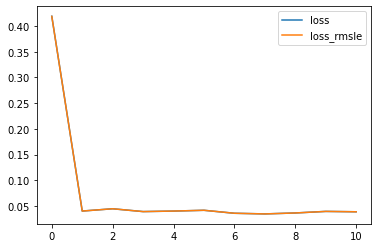

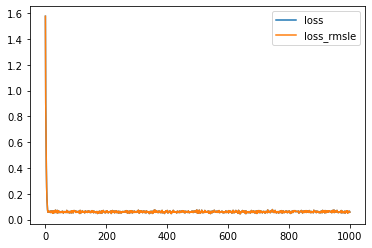

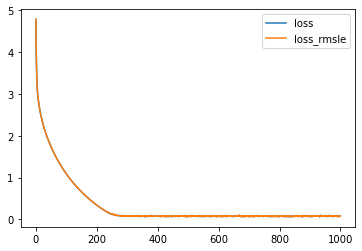

In [ ]:
pd.DataFrame(model0.history.history).plot()
pd.DataFrame(model1.history.history).plot()
pd.DataFrame(model2.history.history).plot()

In [ ]:
model0.save('keras_model0_0821_2.h5')
model1.save('keras_model1_0821_2.h5')
model2.save('keras_model2_0821_2.h5')

In [ ]:
df_test_tail = origin_train.iloc[per_step*-1:,:-3].copy()
df_test = origin_test.copy()
df_test = pd.concat([df_test_tail,df_test],axis = 0)
df_test,datatime_test = feature_engine(df_test)
df_test.head()

,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,hour,month,mean_deg_c
0,47.2,0.5632,855.0,612.1,981.4,876.1,594.7,0.916667,0.847222,10.1
1,46.0,0.5546,807.0,633.9,1088.3,893.8,520.9,1.000000,0.833333,9.8
2,44.7,0.5489,890.4,619.8,1035.9,910.4,579.7,0.916667,0.847222,9.2
3,44.0,0.5355,781.8,584.0,1209.5,895.6,465.5,0.833333,0.861111,8.9
4,46.6,0.5153,843.8,539.6,1282.6,793.3,427.5,0.750000,0.875000,9.4


In [ ]:
#df_test = pd.DataFrame(min_max_scaler.fit_transform(df_test))
df_test = df_to_series(df_test)

In [ ]:
pred0 = model0.predict(df_test)
pred1 = model1.predict(df_test)
pred2 = model2.predict(df_test)

In [ ]:
result = pd.DataFrame(datatime_test[per_step:].reset_index(drop=True))
result = pd.concat([result,pd.DataFrame(np.concatenate([pred0,pred1,pred2],axis=1))],axis = 1)
summit_columns = pd.read_csv('E:\jupyter\mygithub\Tabular-Playground-Series\sample_submission.csv').columns
result.columns=summit_columns
result.to_csv('keras_sub_0822_01.csv',index = False)